# Training Analysis
First let's create some helper functions so that we can visualize and track our training results.
For every training, we first run a learning rate run, to determine, which learning rate to use for the actual training. So each training has at least two runs.

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
# helper functions for the plots

def plot_single_history(path_to_train_history, adjust_scales = False, title = ""):

    # Create a figure for plotting all folds
    fig, axes = plt.subplots(3, 2, figsize=(15, 10)) # To visualize both loss and accuracy
    axes = axes.ravel()

    alpha_all = 0.3
    alpha_avg = 0.7

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    # Load the training history
    history = np.load(path_to_train_history, allow_pickle=True).item()
    
    # Plot the loss and accuracy for the current fold
    history_df = pd.DataFrame(history)

    history_df["loss_diff"] = history_df["loss"] - history_df["val_loss"]
    history_df["accuracy_diff"] = history_df["accuracy"] - history_df["val_accuracy"]

    # Plot training and validation loss
    history_df[['loss']].plot(ax=axes[0], color=colors[0], legend=False, alpha=alpha_all)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)

    # Plot training and validation accuracy
    history_df[['accuracy']].plot(ax=axes[1], color=colors[0], legend=False, alpha=alpha_all)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)

    history_df[["val_loss"]].plot(ax=axes[2], color=colors[0], legend=False, alpha=alpha_all)
    axes[2].set_title('Validation Loss')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Val Loss')
    axes[2].grid(True)
    val_loss_y_max = abs(history_df[["val_loss"]].max().values[0])
    # if the maximum value of the val loss is larger than 10, adjust the y-axis
    if adjust_scales:
        if val_loss_y_max > 10:
            axes[2].set_ylim(0, 3)

    history_df[["val_accuracy"]].plot(ax=axes[3], color=colors[0], legend=False, alpha=alpha_all)
    axes[3].set_title('Validation Accuracy')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Val Accuracy')
    axes[3].grid(True)

    history_df[["loss_diff"]].plot(ax=axes[4], color=colors[0], legend=False, alpha=alpha_all)
    axes[4].set_title('Loss Difference between Training and Validation')
    axes[4].set_xlabel('Epochs')
    axes[4].set_ylabel('Loss Difference')
    axes[4].grid(True)
    loss_diff_y_max = abs(history_df[["loss_diff"]].max().values[0])
    loss_diff_y_min = abs(history_df[["loss_diff"]].min().values[0])
    if adjust_scales:
        if loss_diff_y_max > 10 or loss_diff_y_min > 10:
            axes[4].set_ylim(-2, 2)

    history_df[["accuracy_diff"]].plot(ax=axes[5], color=colors[0], legend=False, alpha=alpha_all)
    axes[5].set_title('Accuracy Difference between Training and Validation')
    axes[5].set_xlabel('Epochs')
    axes[5].set_ylabel('Accuracy Difference')
    axes[5].grid(True)

    plt.tight_layout()

    if title != "":
        plt.suptitle(title)

    plt.show()

def plot_single_history_one_graph(path_to_train_history, epochs = 600, title = ""):

    history = np.load(path_to_train_history, allow_pickle=True).item()

    print(history.keys())

    pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                            xlim=(0,epochs),
                            ylim=(0,3),
                            grid=True,
                            xlabel="Epochs",
                            style=["r-","b-"],)
    
    if title != "":
        plt.title(title)

    plt.show()

def plot_training_history(path_to_train_history, title=""):
    """
    Loads and plots the training/validation loss and accuracy from a history file.

    This function automatically finds and annotates the epoch with the highest
    validation accuracy, which is often the best candidate for the final model.

    Args:
        path_to_train_history (str): The file path to the saved training history .npy file.
                                     The history is expected to be a dictionary with keys
                                     'loss', 'val_loss', 'accuracy', 'val_accuracy'.
        title (str, optional): A custom title for the plot. Defaults to "".
    """
    try:
        history = np.load(path_to_train_history, allow_pickle=True).item()
    except FileNotFoundError:
        print(f"Error: The file '{path_to_train_history}' was not found.")
        return

    # Ensure all necessary keys are in the history file
    required_keys = ["loss", "val_loss", "accuracy", "val_accuracy"]
    if not all(key in history for key in required_keys):
        print(f"Error: The history dictionary is missing one of the required keys: {required_keys}")
        print(f"Available keys: {list(history.keys())}")
        return

    # Convert to pandas DataFrame for easy handling
    df = pd.DataFrame(history)
    epochs = len(df)

    # --- Find the best epoch based on validation accuracy ---
    # np.argmax returns the index of the maximum value
    best_epoch_idx = df['val_accuracy'].idxmax()
    
    # Retrieve the values at that best epoch
    best_val_accuracy = df['val_accuracy'].iloc[best_epoch_idx]
    best_val_loss = df['val_loss'].iloc[best_epoch_idx]
    
    # Add 1 to index because epochs are typically 1-based for humans
    best_epoch_num = best_epoch_idx + 1

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Loss on the primary y-axis (ax1)
    color = 'tab:red'
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', color=color, fontsize=12)
    ax1.plot(df.index + 1, df['loss'], 'r-', label='Training Loss')
    ax1.plot(df.index + 1, df['val_loss'], 'm-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for Accuracy that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color, fontsize=12)
    ax2.plot(df.index + 1, df['accuracy'], 'b-', label='Training Accuracy')
    ax2.plot(df.index + 1, df['val_accuracy'], 'c-', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    # --- Add annotation for the best epoch ---
    # Draw a vertical line to mark the best epoch
    plt.axvline(x=best_epoch_num, color='k', linestyle=':', linewidth=2,
                label=f'Best Epoch ({best_epoch_num})')

    # Add an annotation box pointing to the best validation accuracy point
    annotation_text = f'Best val_accuracy: {best_val_accuracy:.4f}\nEpoch: {best_epoch_num}'
    ax2.annotate(annotation_text,
                 xy=(best_epoch_num, best_val_accuracy),
                 xytext=(best_epoch_num + (epochs*0.05), best_val_accuracy - 0.05), # Position text slightly away
                 arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                 fontsize=12,
                 fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="k", lw=1, alpha=0.8))

    # --- Final plot styling ---
    plot_title = "Training & Validation History"
    if title:
        plot_title = f"{title} - {plot_title}"
    plt.title(plot_title, fontsize=16, fontweight='bold')
    
    # Set plot limits
    ax1.set_xlim(0, epochs + 1)
    ax1.set_ylim(0, max(df['loss'].max(), df['val_loss'].max()) * 1.1) # Dynamic y-limit for loss
    ax2.set_ylim(0, 1.05) # Accuracy is between 0 and 1

    fig.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

    # --- Print summary to the console ---
    print("="*50)
    print(f"Training History Analysis for: '{title}'")
    print(f"Total Epochs Trained: {epochs}")
    print("-"*50)
    print(f"Highest Validation Accuracy of {best_val_accuracy:.4f} achieved at Epoch {best_epoch_num}.")
    print(f"Validation Loss at this epoch was {best_val_loss:.4f}.")
    print("="*50)




# --- PLOT HISTORIES ---


def plot_fold_histories(path_to_train_history, title = ""):
    # Define the base path to your training history files
    base_path_to_train_history = path_to_train_history

    # Create a figure for plotting all folds
    fig, axes = plt.subplots(3, 2, figsize=(15, 10)) # To visualize both loss and accuracy
    axes = axes.ravel()

    alpha_all = 0.3
    alpha_avg = 0.7

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    loss_list = []
    val_loss_list = []
    accuracy_list = []
    val_accuracy_list = []
    loss_diff_list = []
    accuracy_diff_list = []

    # Loop through each fold and load the training history
    for fold in range(10):
        # Construct the path for the current fold
        path_to_train_history = base_path_to_train_history + f"{fold}.npy"

        # Load the training history
        history = np.load(path_to_train_history, allow_pickle=True).item()
        
        # Plot the loss and accuracy for the current fold
        history_df = pd.DataFrame(history)

        history_df["loss_diff"] = history_df["loss"] - history_df["val_loss"]
        history_df["accuracy_diff"] = history_df["accuracy"] - history_df["val_accuracy"]

        loss_list.append(history_df["loss"])
        val_loss_list.append(history_df["val_loss"])
        accuracy_list.append(history_df["accuracy"])
        val_accuracy_list.append(history_df["val_accuracy"])
        loss_diff_list.append(history_df["loss_diff"])
        accuracy_diff_list.append(history_df["accuracy_diff"])

        # Plot training and validation loss
        history_df[['loss']].plot(ax=axes[0], color=colors[fold], legend=False, alpha=alpha_all)
        axes[0].set_title('Training Loss (All Folds & Average)')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True)

        # Plot training and validation accuracy
        history_df[['accuracy']].plot(ax=axes[1], color=colors[fold], legend=False, alpha=alpha_all)
        axes[1].set_title('Training Accuracy (All Folds & Average)')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(True)

        history_df[["val_loss"]].plot(ax=axes[2], color=colors[fold], legend=False, alpha=alpha_all)
        axes[2].set_title('Validation Loss (All Folds & Average)')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('Val Loss')
        axes[2].grid(True)

        history_df[["val_accuracy"]].plot(ax=axes[3], color=colors[fold], legend=False, alpha=alpha_all)
        axes[3].set_title('Validation Accuracy (All Folds & Average)')
        axes[3].set_xlabel('Epochs')
        axes[3].set_ylabel('Val Accuracy')
        axes[3].grid(True)

        history_df[["loss_diff"]].plot(ax=axes[4], color=colors[fold], legend=False, alpha=alpha_all)
        axes[4].set_title('Loss Difference between Training and Validation (All Folds & Average)')
        axes[4].set_xlabel('Epochs')
        axes[4].set_ylabel('Loss Difference')
        axes[4].grid(True)

        history_df[["accuracy_diff"]].plot(ax=axes[5], color=colors[fold], legend=False, alpha=alpha_all)
        axes[5].set_title('Accuracy Difference between Training and Validation (All Folds & Average)')
        axes[5].set_xlabel('Epochs')
        axes[5].set_ylabel('Accuracy Difference')
        axes[5].grid(True)

    # Add a legend for clarity (for different folds)
    for i in range(6):
        axes[i].legend([f'Fold {i+1}' for i in range(10)], loc='upper right', fontsize='small')

    # Calculate average metrics across all folds
    avg_loss = pd.concat(loss_list, axis=1).mean(axis=1)
    avg_val_loss = pd.concat(val_loss_list, axis=1).mean(axis=1)
    avg_accuracy = pd.concat(accuracy_list, axis=1).mean(axis=1)
    avg_val_accuracy = pd.concat(val_accuracy_list, axis=1).mean(axis=1)
    avg_loss_diff = pd.concat(loss_diff_list, axis=1).mean(axis=1)
    avg_accuracy_diff = pd.concat(accuracy_diff_list, axis=1).mean(axis=1)

    avg_loss.plot(ax=axes[0], color='black', linestyle='-', label='Average Loss')
    avg_val_loss.plot(ax=axes[2], color='black', linestyle='-', label='Average Val Loss')

    avg_accuracy.plot(ax=axes[1], color='black', linestyle='-', label='Average Accuracy')
    avg_val_accuracy.plot(ax=axes[3], color='black', linestyle='-', label='Average Val Accuracy')

    avg_loss_diff.plot(ax=axes[4], color='black', linestyle='-', label='Average Loss Diff')
    avg_accuracy_diff.plot(ax=axes[5], color='black', linestyle='-', label='Average Accuracy Diff')

    plt.tight_layout()

    if title != "":
        plt.suptitle(title)
        
    plt.show()

def plot_lr_history(path_to_train_history, title = ""):

    path_to_train_history = path_to_train_history

    history = np.load(path_to_train_history, allow_pickle=True).item()

    plt.semilogx(history["lr"], history["loss"])
    plt.title("loss vs. learning rate")
    plt.axis([1e-8, 1e-1, 0, 3])

    if title != "":
        title = title + " - loss vs. learning rate"
        plt.title(title)

    print("Epochs: ", len(history["loss"]))

def plot_lr_history(path_to_train_history, title: str = ""):
    """Plot loss vs. learning-rate from a history npy file and highlight the best lr.

    Parameters
    ----------
    path_to_train_history : str
        Path to a saved history dictionary with keys "lr" and "loss".
    title : str, optional
        Optional prefix for the plot title.

    Returns
    -------
    float
        The learning rate that produced the lowest loss.
    """
    # --- load history --------------------------------------------------------
    try:
        # Load the history dictionary from the numpy file
        history = np.load(path_to_train_history, allow_pickle=True).item()
        lrs = history["lr"]
        losses = history["loss"]
    except FileNotFoundError:
        print(f"Error: The file '{path_to_train_history}' was not found.")
        return None, None
    except KeyError:
        print("Error: The history file must contain 'lr' and 'loss' keys.")
        return None, None
    
    min_loss_idx = np.argmin(losses)

    min_loss_value = losses[min_loss_idx]
    best_lr = lrs[min_loss_idx]

    # --- basic plot ----------------------------------------------------------
    plt.figure(figsize=(12, 6))
    plt.semilogx(lrs, losses)
    plt.xlabel("Learning Rate (log scale)", fontsize=12)
    plt.ylabel("loss", fontsize=12)
    plt.axis([1e-8, 1e-1, 0, 5])
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)


    # --- highlight the best point -------------------------------------------
    best_idx  = np.argmin(losses)
    best_lr   = lrs[best_idx]
    best_loss = losses[best_idx]

    # red dot on the curve
    plt.scatter(best_lr, best_loss, color="red", zorder=5)
    # annotate slightly to the upper right of the point
    plt.annotate(
        f"lowest loss = {best_loss:.4f}\nlr = {best_lr:.2e}\n",
        xy=(best_lr, best_loss),
        xytext=(0.03, 0.85),            # axes-fraction coordinates
        textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", lw=1),
        fontsize=9,
        horizontalalignment="left",
        verticalalignment="top"
    )

    # --- title & housekeeping -----------------------------------------------
    full_title = "loss vs. learning rate" if not title else f"{title} – loss vs. learning rate"
    plt.title(full_title)
    #plt.tight_layout()

    # --- console output ------------------------------------------------------
    print(f"Epochs: {len(losses)}")
    print(f"Lowest loss {best_loss:.4f} at learning rate {best_lr:.2e}")

    return best_lr

In [9]:
training_df = pd.DataFrame()
training_histories = {}

In [10]:
def add_training_history_to_df(path_to_train_history, model_architecture = "", training_description = "", training_modification = ""):
    
    global training_df

    data = np.load(path_to_train_history, allow_pickle=True).item()

    # Ensure the data contains the keys 'loss', 'val_loss', 'acc', and 'val_accuracy'
    val_loss = data['val_loss']
    val_accuracy = data['val_accuracy']

    # Calculate the desired metrics
    min_val_loss = np.around(np.min(val_loss), decimals=4)  # Minimum validation loss
    min_val_loss_index = np.argmin(val_loss)  # Epoch index of minimum validation loss
    val_accuracy_at_min_val_loss = np.around(val_accuracy[min_val_loss_index], decimals=4)  # Validation accuracy at minimum validation loss
    best_val_accuracy = np.around(np.max(val_accuracy), decimals=4)  # Best validation accuracy

    # Create a DataFrame to display the results

    # new_row = {
    #     (training_description, training_modification): {
    #         (model_architecture, "Min Val Loss"): min_val_loss,
    #         (model_architecture, "Val Accuracy at Min Val Loss"): val_accuracy_at_min_val_loss,
    #         (model_architecture, "Best Val Accuracy"): best_val_accuracy
    #     }
    # }

    training_histories[(training_description, model_architecture, training_modification)] = {
        "Min Val Loss": min_val_loss,
        "Val Accuracy at Min Val Loss": val_accuracy_at_min_val_loss,
        "Best Val Accuracy": best_val_accuracy
    }

    # new_row_df = pd.DataFrame.from_dict(new_row)

    # training_df = pd.concat([training_df, new_row_df], axis=0)


## Training 5 classes

### Control Conv

#### Learning Rate

Epochs: 400
Lowest loss 1.9375 at learning rate 2.36e-03


0.0023577623069286346

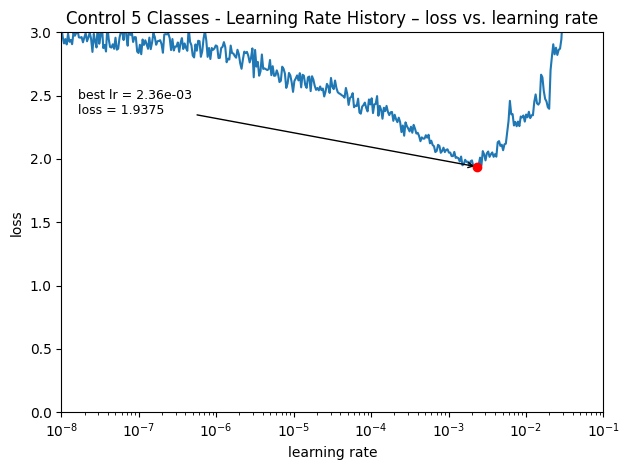

In [17]:
path_to_control_5_classes_lr_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/5_classes_training/control_conv/conv_00_5cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_06_20_15_10_22/history_conv_00_5cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_06_20_15_10_22.npy')

plot_lr_history(path_to_control_5_classes_lr_history, title="Control 5 Classes - Learning Rate History")

I'll pick a learning rate of 2 x 10^-3

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


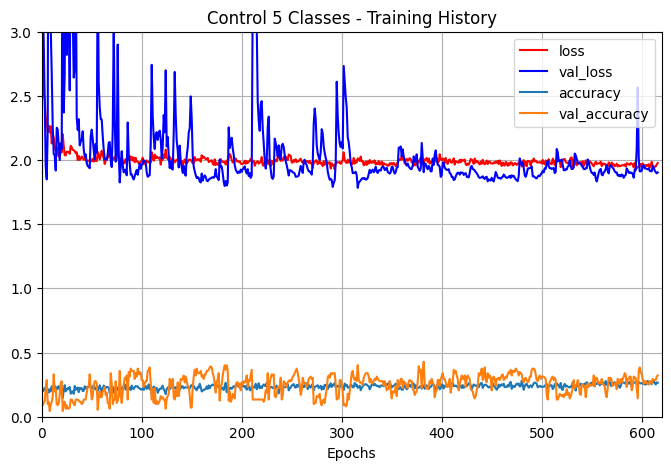

In [14]:
path_to_control_5_classes_train_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/5_classes_training/control_conv/conv_00_5cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_02_08_15_01/history_conv_00_5cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_02_08_15_01.npy')

plot_single_history_one_graph(path_to_control_5_classes_train_history, epochs=620, title="Control 5 Classes - Training History")

Best Epoch\
Epoch 317/1500\
21/21 [==============================] - 2s 100ms/step - loss: 2.0125 - accuracy: 0.2250 - val_loss: 1.7838 - val_accuracy: 0.4018

Best Epoch: 74

## Training 2 classes
### Control Conv

Epochs: 400
Lowest loss 1.0180 at learning rate 1.14e-03


0.0011415632907301188

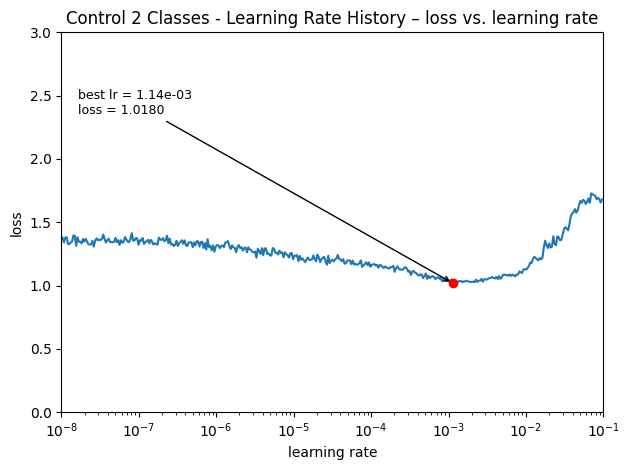

In [18]:
path_to_control_5_classes_lr_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/2_classes_training/control_conv/conv_00_2cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_06_20_16_23_04/history_conv_00_2cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_06_20_16_23_04.npy')

plot_lr_history(path_to_control_5_classes_lr_history, title="Control 2 Classes - Learning Rate History")

I'll pick a learning rate of 3 x 10^-3

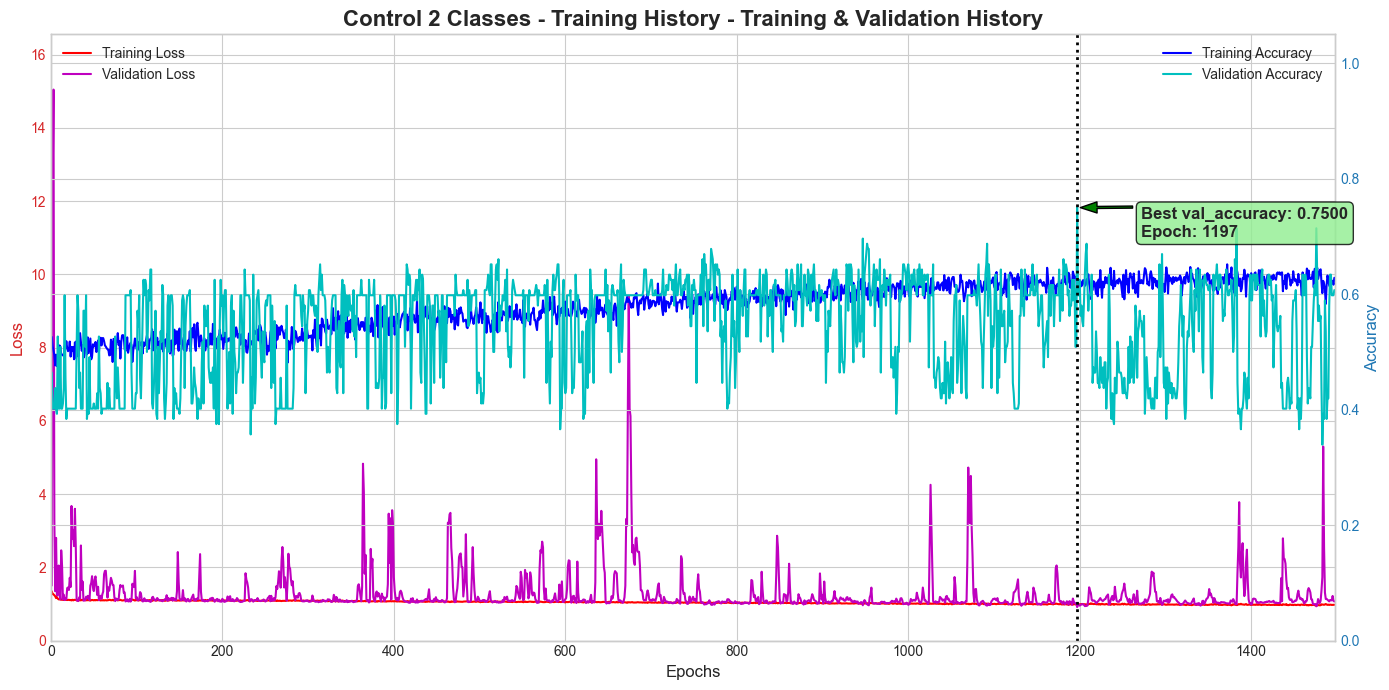

Training History Analysis for: 'Control 2 Classes - Training History'
Total Epochs Trained: 1497
--------------------------------------------------
Highest Validation Accuracy of 0.7500 achieved at Epoch 1197.
Validation Loss at this epoch was 0.9144.


In [31]:
path_to_control_2_classes_train_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/2_classes_training/control_conv/conv_00_2cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_01_10_51_43/history_conv_00_2cls_slice_no_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_01_10_51_43.npy')

#plot_single_history_one_graph(path_to_control_2_classes_train_history, epochs=1500, title="Control 2 Classes - Training History")
plot_training_history(path_to_control_2_classes_train_history, title="Control 2 Classes - Training History")

Best Epoch \
Epoch 1197 \
21/21 [==============================] - 3s 119ms/step - loss: 0.9900 - accuracy: 0.6052 - auc: 0.6553 - precision: 0.6243 - recall: 0.6592 - val_loss: 0.9144 - val_accuracy: 0.7500 - val_auc: 0.7872 - val_precision: 0.6977 - val_recall: 0.6667


### With Clinical Data

Epochs: 400
Lowest loss 1.0252 at learning rate 1.85e-03


0.0018513988

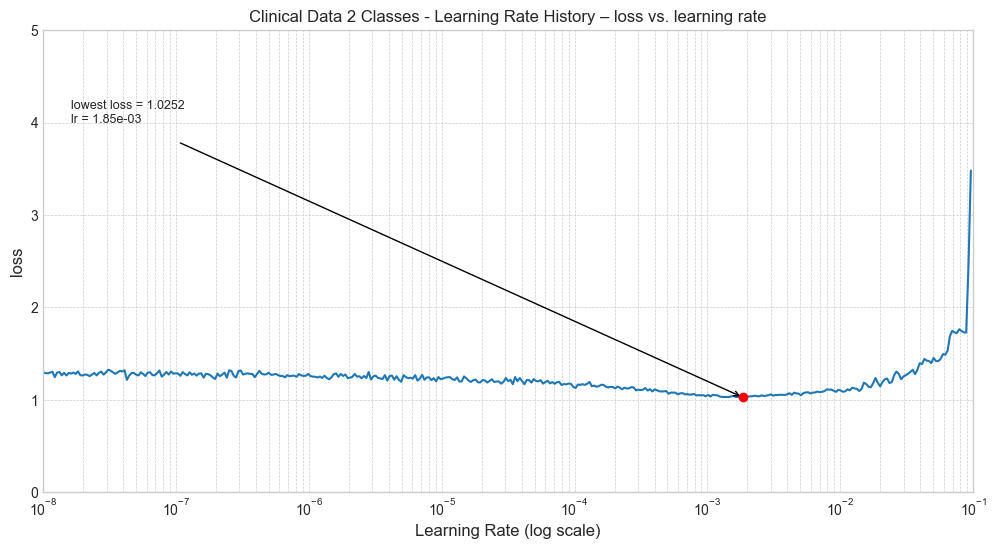

In [38]:
path_to_clinical_data_2_classes_lr_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/2_classes_training/clin_data/conv_00_2cls_slice_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_07_01_12_20_12/history_conv_00_2cls_slice_clin_no_layer_gray_seq[t1c]_normal_DA_lr_run_2025_07_01_12_20_12.npy')

plot_lr_history(path_to_clinical_data_2_classes_lr_history, title="Clinical Data 2 Classes - Learning Rate History")

I'll pick a learning rate of 2 x 10^-3

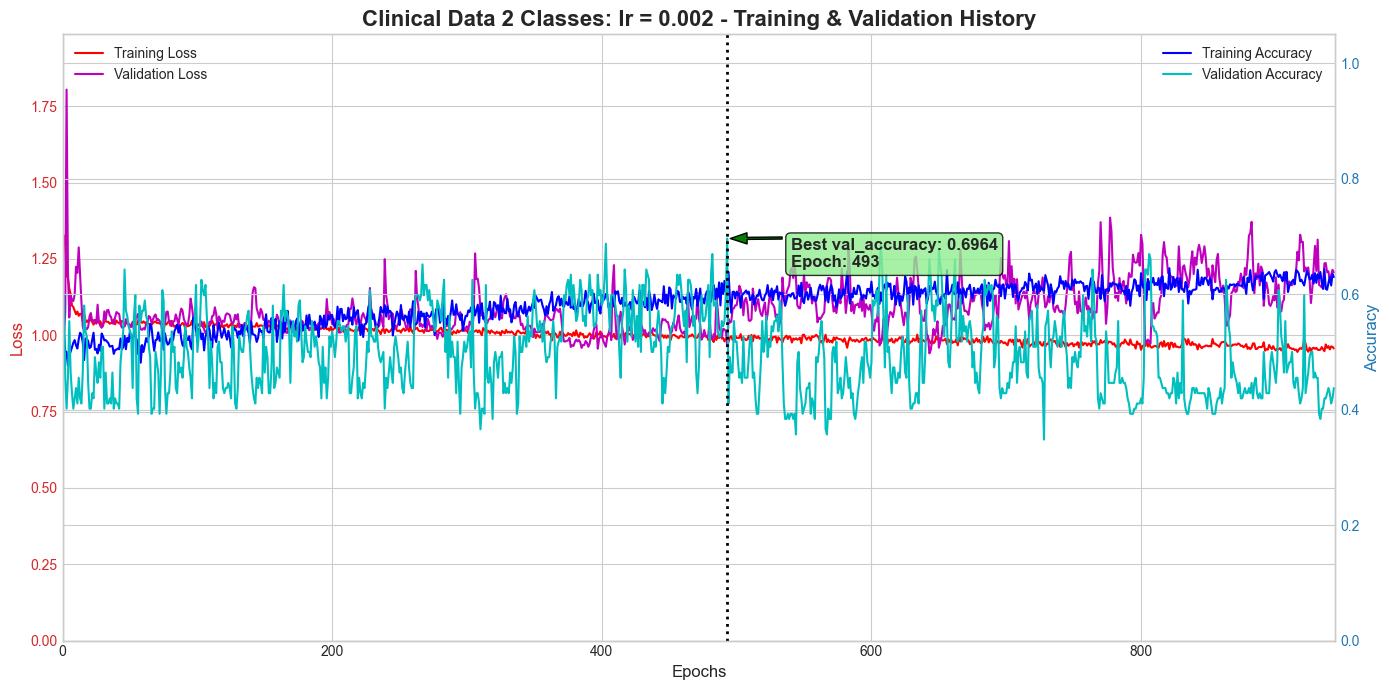

Training History Analysis for: 'Clinical Data 2 Classes: lr = 0.002'
Total Epochs Trained: 943
--------------------------------------------------
Highest Validation Accuracy of 0.6964 achieved at Epoch 493.
Validation Loss at this epoch was 0.9637.


In [33]:
path_to_clin_2_classes_train_history = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/2_classes_training/clin_data/conv_00_2cls_slice_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_02_09_05_09/history_conv_00_2cls_slice_clin_no_layer_gray_seq[t1c]_normal_DA_normal_run_2025_07_02_09_05_09.npy')

#plot_single_history_one_graph(path_to_control_2_classes_train_history, epochs=1500, title="Control 2 Classes - Training History")
plot_training_history(path_to_clin_2_classes_train_history, title="Clinical Data 2 Classes: lr = 0.002")

Best Epoch\
Epoch 643/1500\
21/21 [==============================] - 2s 102ms/step - loss: 0.9812 - accuracy: 0.6145 - auc: 0.6499 - precision: 0.6531 - recall: 0.5970 - val_loss: 0.9405 - val_accuracy: 0.6607 - val_auc: 0.7161 - val_precision: 0.6129 - val_recall: 0.4222

### With Layer Number

### All Sequences

### With Mask

### With Pretraining